# Computing the 'variance' of Embedding Vectors

We want a way to quantify improvements to the responses of LLMs. Because they're non-deterministic we need to take multiple samples.

Then we need to compare two such distributions of responses. We theorise that the variance between individual responses iun a sample might be a useful metric, so we need a way to obtain that.

We theorise that we can compute a 'central' vector within the sample of embedding vectors and then determine each vector's distance from that centre.

How we compute the centre and how we compute the distance are to be determined, but we'll start with the element-wise mean of the sample and then the element-wise variance and see how that looks.

In [20]:
import yaml
import os
import json
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

In [6]:
from openai import OpenAI
import os
import yaml
from langchain_openai import ChatOpenAI

# Set up your OpenAI API key
with open('openai.yaml', 'r') as f:
    config = yaml.safe_load(f)

os.environ['OPENAI_API_KEY'] = config['openai_key']

# initialise the OpenAI connection
llm = ChatOpenAI()
client = OpenAI()

In [7]:
# first a couple of sample prompts
clear_prompt = 'Describe the process of photosynthesis in plants, focusing specifically on the roles of sunlight, carbon dioxide, and chlorophyll.'
unclear_prompt = 'Talk about plants and their importance.'
unrelated_prompt = 'How can I combine 18 quarks together and what will that let me do?'

In [35]:
# get responses
clear_responses = [llm.invoke(clear_prompt).content for _ in range(100)]
unclear_responses = [llm.invoke(unclear_prompt).content for _ in range(100)]
#unrelated_responses = [llm.invoke(unrelated_prompt).content for _ in range(100)]

In [8]:
#Get the embedding vectors from OAI API
def fetch_oai_embeddings(input_strings:list,
                         embedding_model: str,
                         oai_client:OpenAI)-> list:

    responses = []

    #Get the embedding values for each input in your list
    #Probably a way to do this async
    for input_string in input_strings:
        response = oai_client.embeddings.create(
            input=input_string,
            model=embedding_model)
        responses.append(response.data[0].embedding)

    return responses

In [10]:
clear_responses[:10]

['Photosynthesis is the process by which plants, algae, and some bacteria convert light energy, usually from the sun, into chemical energy stored in glucose. This process occurs in the chloroplasts of plant cells and involves several key components: sunlight, carbon dioxide, and chlorophyll.\n\n1. Sunlight: Sunlight is the primary source of energy for photosynthesis. Plants contain specialized pigments called chlorophyll that are able to absorb light energy. When sunlight hits the chlorophyll molecules, it excites electrons and starts the process of photosynthesis.\n\n2. Carbon dioxide: Plants take in carbon dioxide from the air through small openings called stomata on their leaves. This carbon dioxide is combined with water in a series of chemical reactions to produce glucose, a simple sugar that serves as the primary source of energy for the plant.\n\n3. Chlorophyll: Chlorophyll is a green pigment found in the chloroplasts of plant cells. It plays a crucial role in photosynthesis by 

In [11]:
# recover the embeddings
clear_embeddings = fetch_oai_embeddings(clear_responses, 'text-embedding-ada-002', client)

In [37]:
unclear_embeddings = fetch_oai_embeddings(unclear_responses, 'text-embedding-ada-002', client)

The Maths

In [18]:
# find the central vector

# try using element-wise mean for this

central_vector_clear = np.mean(clear_embeddings, axis=0)
len(central_vector_clear)

1536

In [26]:
# find the distances from the central vector

# try using the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_clear = cosine_similarity([central_vector_clear], clear_embeddings)
cos_sim_clear

array([[0.99087654, 0.98644694, 0.98896937, 0.9908477 , 0.98995523,
        0.98575295, 0.98950468, 0.98871091, 0.98888248, 0.99031801,
        0.99095326, 0.98840844, 0.98943559, 0.99294011, 0.98895774,
        0.99178355, 0.98707899, 0.98858469, 0.98883804, 0.98785019,
        0.98782573, 0.99139384, 0.99148021, 0.99040757, 0.98831464,
        0.99217602, 0.99172352, 0.9919975 , 0.99467422, 0.99004824,
        0.98490834, 0.99215396, 0.97894527, 0.98393804, 0.98967161,
        0.99148625, 0.99163237, 0.98958834, 0.99097126, 0.98966236,
        0.99260529, 0.99217362, 0.98822405, 0.99181363, 0.98921002,
        0.99349881, 0.98539249, 0.98917667, 0.99043451, 0.98835169,
        0.98646533, 0.99191919, 0.99113019, 0.99334515, 0.98443702,
        0.9927028 , 0.9924832 , 0.99123192, 0.99299143, 0.99406353,
        0.98881752, 0.98961385, 0.99418653, 0.98530088, 0.99127965,
        0.98986849, 0.98155058, 0.98902696, 0.99106471, 0.99170264,
        0.99143057, 0.99074494, 0.98851293, 0.99

<Axes: ylabel='Density'>

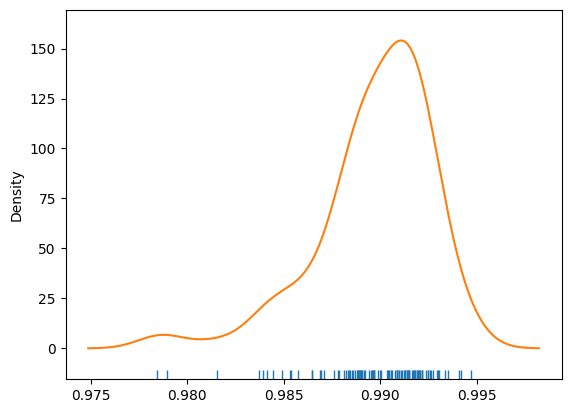

In [31]:
sns.rugplot(cos_sim_clear[0])
sns.kdeplot(cos_sim_clear[0])

In [32]:
# first attempt at a variance metric
# we compute the median of the cosine similarities
med_cos_sim_clear = np.median(cos_sim_clear[0])
med_cos_sim_clear

0.9904210371797124

In [34]:
# now variance
var_cos_sim_clear = np.var(cos_sim_clear[0], dtype=np.float64)
var_cos_sim_clear

8.733423196957083e-06

In [36]:
clear_responses[88]

"Photosynthesis is the process by which plants, algae, and some bacteria convert sunlight into energy to fuel their growth and metabolism. The process of photosynthesis can be broken down into two main stages: the light-dependent reactions and the light-independent reactions (Calvin cycle).\n\nIn the light-dependent reactions, sunlight is absorbed by chlorophyll, a pigment found in the chloroplasts of plant cells. Chlorophyll absorbs sunlight and uses it to split water molecules into oxygen, protons, and electrons. This process is known as photolysis. The oxygen is released into the atmosphere as a byproduct, while the protons and electrons are used to generate ATP (adenosine triphosphate) and NADPH (nicotinamide adenine dinucleotide phosphate), which are energy-rich molecules that fuel the light-independent reactions.\n\nIn the light-independent reactions, also known as the Calvin cycle, carbon dioxide from the atmosphere is taken up by the plant and combined with the ATP and NADPH ge

In [39]:
central_vector_unclear = np.mean(unclear_embeddings, axis=0)
cos_sim_unclear = cosine_similarity([central_vector_unclear], unclear_embeddings)
var_cos_sim_unclear = np.var(cos_sim_unclear[0], dtype=np.float64)
var_cos_sim_unclear

7.814961600699007e-06

<Axes: ylabel='Density'>

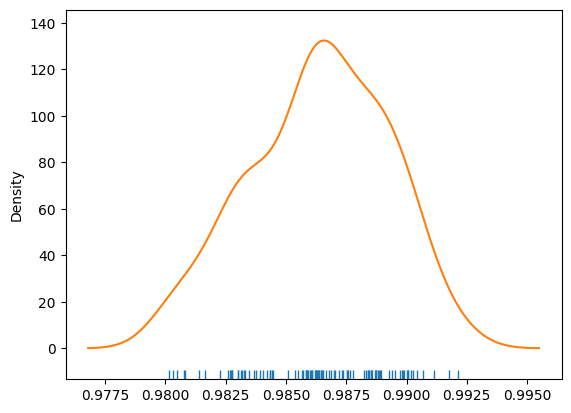

In [40]:
sns.rugplot(cos_sim_unclear[0])
sns.kdeplot(cos_sim_unclear[0])

<Axes: ylabel='Density'>

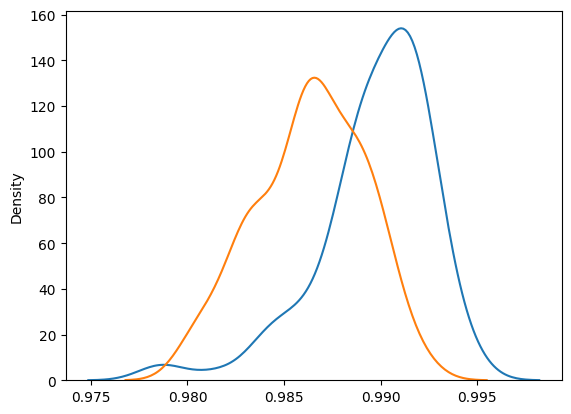

In [41]:
sns.kdeplot(cos_sim_clear[0])
sns.kdeplot(cos_sim_unclear[0])

<Axes: >

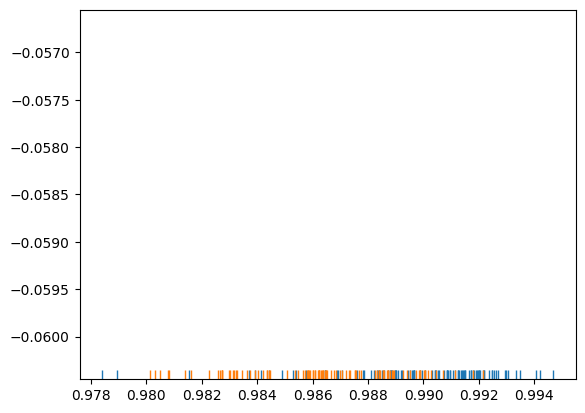

In [42]:
sns.rugplot(cos_sim_clear[0])
sns.rugplot(cos_sim_unclear[0])